## Solving the cartpole problem with the ANNarchy-NEAT extension

In this Notebook we will use the ANNarchy-NEAT extension to generate spiking neural networks to solve the Cartpole problem included in the Farama Gymnasium reinforcement learning benchmark set.

First we will import ANNarchy to simulate the spiking neural network and gymnasium for the environment.

In [1]:
%pip install ANNarchy
%pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


We now import the additional code where the NEAT algorithms is implemented. This is taken from the repository where the code of the Baladron et al. (2025) paper is stored.

In [1]:
import requests

url = "https://github.com/bastianloyola/NEAT-ANNarchy/raw/refs/heads/main/neatannarchy.py"
file_name = "neatannarchy.py"
response = requests.get(url)

if response.status_code == 200:
    with open(file_name, "wb") as file:
        file.write(response.content)
    print(f"File saved and stored as '{file_name}'.")
else:
    print(f"Error downloading the file: {response.status_code}")


File saved and stored as 'neatannarchy.py'.


We now import the necessary libraries including ANNarchy and the necesary scientific code.

In [3]:
from ANNarchy import *
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import scipy.sparse
import gymnasium as gym
from scipy.special import erf

ANNarchy 4.7 (4.7.3) on linux (posix).


# Neuron model
We now define the neuron model to use. We then copy the model definition to a file named neuronmodel.py.

For more information regarding how to define neuron modesl in ANNarchy go to https://annarchy.readthedocs.io/API/Neuron.html


In [4]:
%%writefile neuronmodel.py

from ANNarchy import *


IZHIKEVICH = Neuron(  #I = 20
    parameters="""
        a = 0.02 : population
        b = 0.2 : population
        c = -65.0 : population
        d = 8.0 : population
        I = 0.0
        tau_I = 10.0 : population
    """,
    equations="""
        dv/dt = 0.04*v*v + 5*v + 140 - u + I + g_exc - g_inh : init=-65
        tau_I * dg_exc/dt = -g_exc
        tau_I * dg_inh/dt = -g_inh
        du/dt = a*(b*v - u) : init=-14.0
    """,
    spike="v >= 30.0",
    reset="v = c; u += d"
)

Writing neuronmodel.py


# Fitness function

---
Next, we define the fitness function which includes the coding scheme for the input and outputs. The fitness function must return a value of the quality of the network. The NEAT algorithm will search for networks that maximize this value.

Para los ejemplos planteados se utilizará la libreria gymnsaium que permite la implementación de problemas de aprendizaje por refuerzo. Actualmente el algoritmo evolutivo maximiza el fitness, por lo que si se tiene un problema de minimización se debe adecuar por el momento al evaluar la función objetivo.



We will use the gymnasium implementation of the cartpole problem to simulate 100 episodes of the task. For each step, first the input neurons will be activated according to the coding scheme used and the current state values, then the network will be simulated for 50ms and finally the decision read by determine which of the output neurons emmited more spikes. The fitness of a network is then the mean return over the 100 episodes.

In [5]:
%%writefile fitness.py

from ANNarchy import *
import gymnasium as gym
import numpy as np


def cartpole(pop,Monitor,input_index,output_index,inputWeights, genome_id):
    env = gym.make("CartPole-v1")
    observation, info = env.reset()
    terminated = False
    truncated = False
    maxInput = inputWeights[1]
    minInput = inputWeights[0]
    #Generate 4 input weights for each input
    np.random.seed(int(genome_id))
    inputWeights = np.random.uniform(minInput,maxInput,4)
    #Number of episodes
    episodes = 100
    h=0
    #Final fitness
    final_fitness = 0

    # Limits for each observation variable
    limits = [
        (-4.8, 4.8),  # Cart position
        (-10.0, 10.0),  # Cart velocity (estimated)
        (-0.418, 0.418),  # Pole angle in radians
        (-10.0, 10.0)  # Pole angular velocity (estimated)
    ]
    def normalize(value, min_val, max_val):
        return (value - min_val) / (max_val - min_val)

    while h < episodes:
        j=0
        returns = []
        actions_done = []
        terminated = False
        truncated = False
        env.reset()
        while not terminated and not truncated:
            #encode observation, 4 values split in 8 neurons (2 for each value), if value is negative the left neuron is activated, if positive the right neuron is activated
            i = 0
            k = 0
            for val in observation:
                print(k)
                print("len(input_index):",input_index)
                print("output_index:",output_index)
                print("len(inputWeights):",len(inputWeights))
                print("limits[k]:",limits[k][0])
                print("input_index[i]:",input_index[i])
                if val < 0:
                    val = normalize(val, limits[k][0], limits[k][1])
                    pop[int(input_index[i])].I = -val*inputWeights[k]
                    pop[int(input_index[i+1])].I = 0
                else:
                    val = normalize(val, limits[k][0], limits[k][1])
                    pop[int(input_index[i])].I = 0
                    pop[int(input_index[i+1])].I = val*inputWeights[k]
                i += 2
                k += 1
                print("val normalized:",val)
            simulate(50.0)
            spikes = Monitor.get('spike')
            #Output from 2 neurons, one for each action
            output1 = np.size(spikes[output_index[0]])
            output2 = np.size(spikes[output_index[1]])
            #Choose the action with the most spikes
            action = env.action_space.sample()
            if output1 > output2: #left
                action = 0
            elif output1 < output2: #right
                action = 1
            observation, reward, terminated, truncated, info = env.step(action)
            returns.append(reward)
            actions_done.append(action)
            pop.reset()
            Monitor.reset()
            j += 1
        #The fitness is the sum of the rewards for each episode
        final_fitness += np.sum(returns)
        h += 1
    #The final fitness is the mean of the fitness for each episode
    final_fitness = final_fitness/episodes
    env.close()
    return final_fitness

Writing fitness.py


# Hyperparameters

We will now create a folder where we will store all the required configuration files.

In [6]:
%mkdir -p config

Each configuration file must define the following parameters:

- keep: percentage of the population that will remain after the elimination process
- threshold: Threshold for the difference between an individual and the representative of a species to incorporate them into a species
- interSpecieRate: probabilidad de generar un entrecruzamiento entre individuos de distintas especies
- noCrossoverOff: probability of a crossover between individuals of different species.
- probabilityWeightMutated: Probability that a weight is perturbed.
- probabilityAddNodeSmall: Probability that a node is created for a small network
- probabilityAddLink_small: Probability that a connection is created for a small network
- probabilityAddNodeLarge: Probability that a node is created for a large network
- probabilityAddLink_Large: Probability that a connection is created for a large network
- c1, c2 y c3: Factors used during the speciation
- largeSize: Number of neurons needed to consider a network as large
- numberInputs: Number of input neurons
- numberOutputs: Number of output neurons
- n_max: Maximum number of neurons a network
- learningRate: Maximum value of a weight perturbation
- inputWeights: Values used to modulate the input values while computing the fitness.
- weightsRange: Initial possible range of values for the initial random weights(n < m).

In [7]:
%%writefile config/config.cfg
keep=0.577
threshold=3.241
interSpeciesRate=0.000549
noCrossoverOff=0.329
probabilityWeightMutated=0.851
probabilityAddNodeSmall=0.0305
probabilityAddLink_small=0.0436
probabilityAddNodeLarge=0.0417
probabilityAddLink_Large=0.0789
largeSize=20
c1=0.53
c2=0.959
c3=0.306
numberInputs=8
numberOutputs=2
n_max=200
learningRate=5
inputWeights=110,150
weightsRange=-20,80

Writing config/config.cfg


We still need to define a few more parameters.

- func: Name of the fitness function
- neuron_model: Name of the neuron model
- process: Amount of parallel processes used while computing the fitness values.
- evolutions: Amount of iterations of the NEAT main loop
- population: Amount of genomes

# Ejemplo 1 Cartpole A LIF

In [1]:
func = "cartpole"
neuron_model = "IZHIKEVICH"
process = 5
evolutions = 20
population = 50

Finally we execute NEAT and obtain the fitness of the best network found.

In [2]:
from neatannarchy import runNEAT, fitness_value, plot_information   
trial = 1

In [2]:
runNEAT(trial, func, neuron_model, process, evolutions, population)

In [3]:
print("Fitness:",fitness_value(trial))

Fitness: 281.82


Datos guardados en results/trial-1/output.json


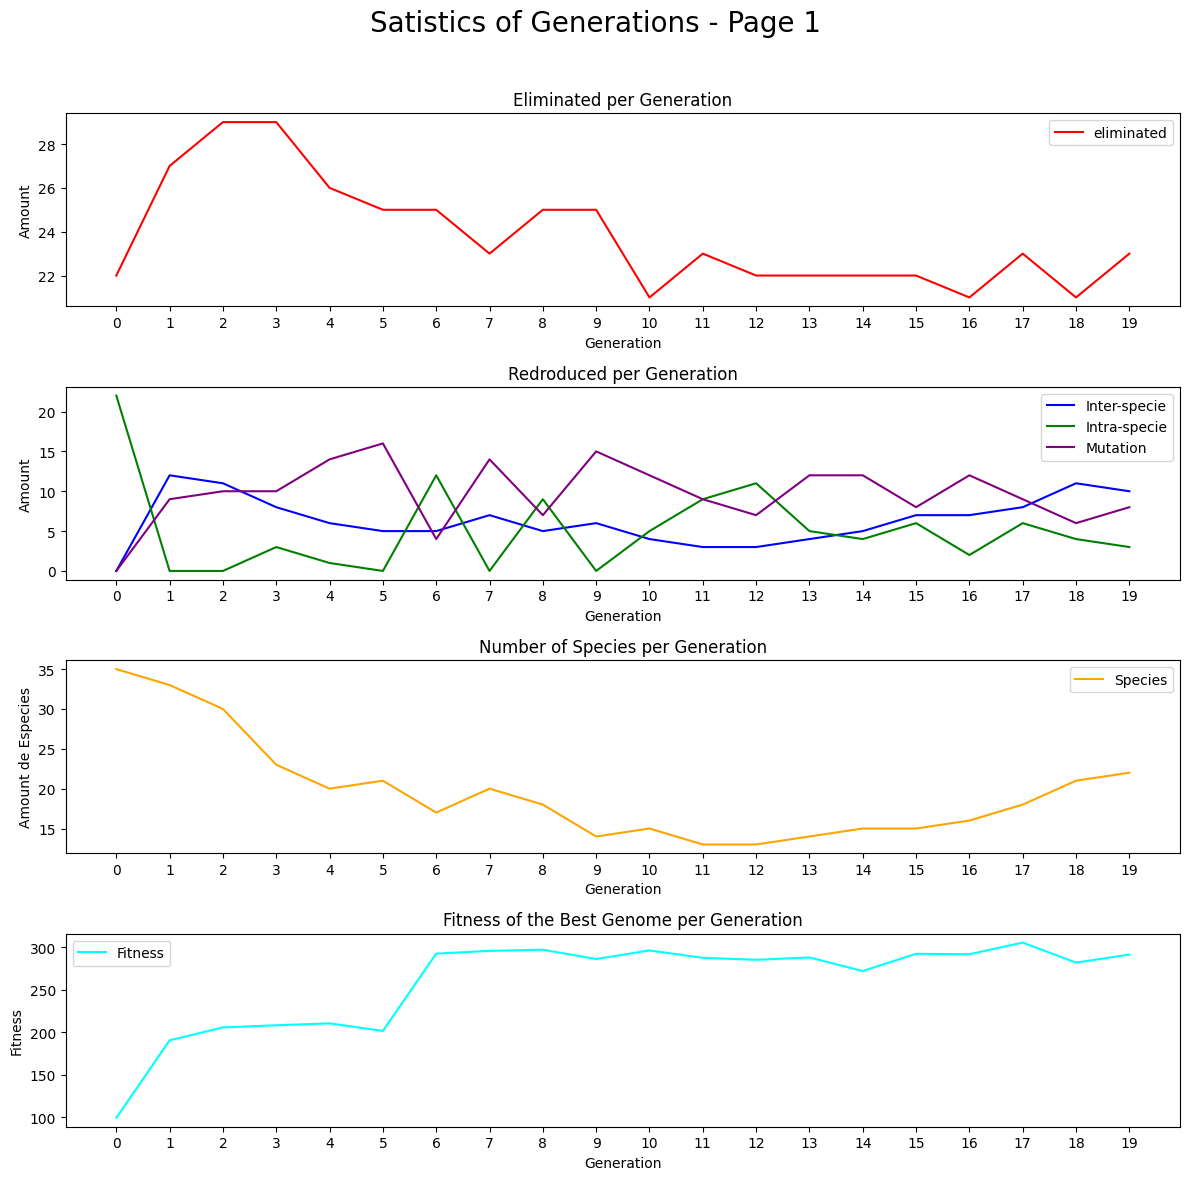

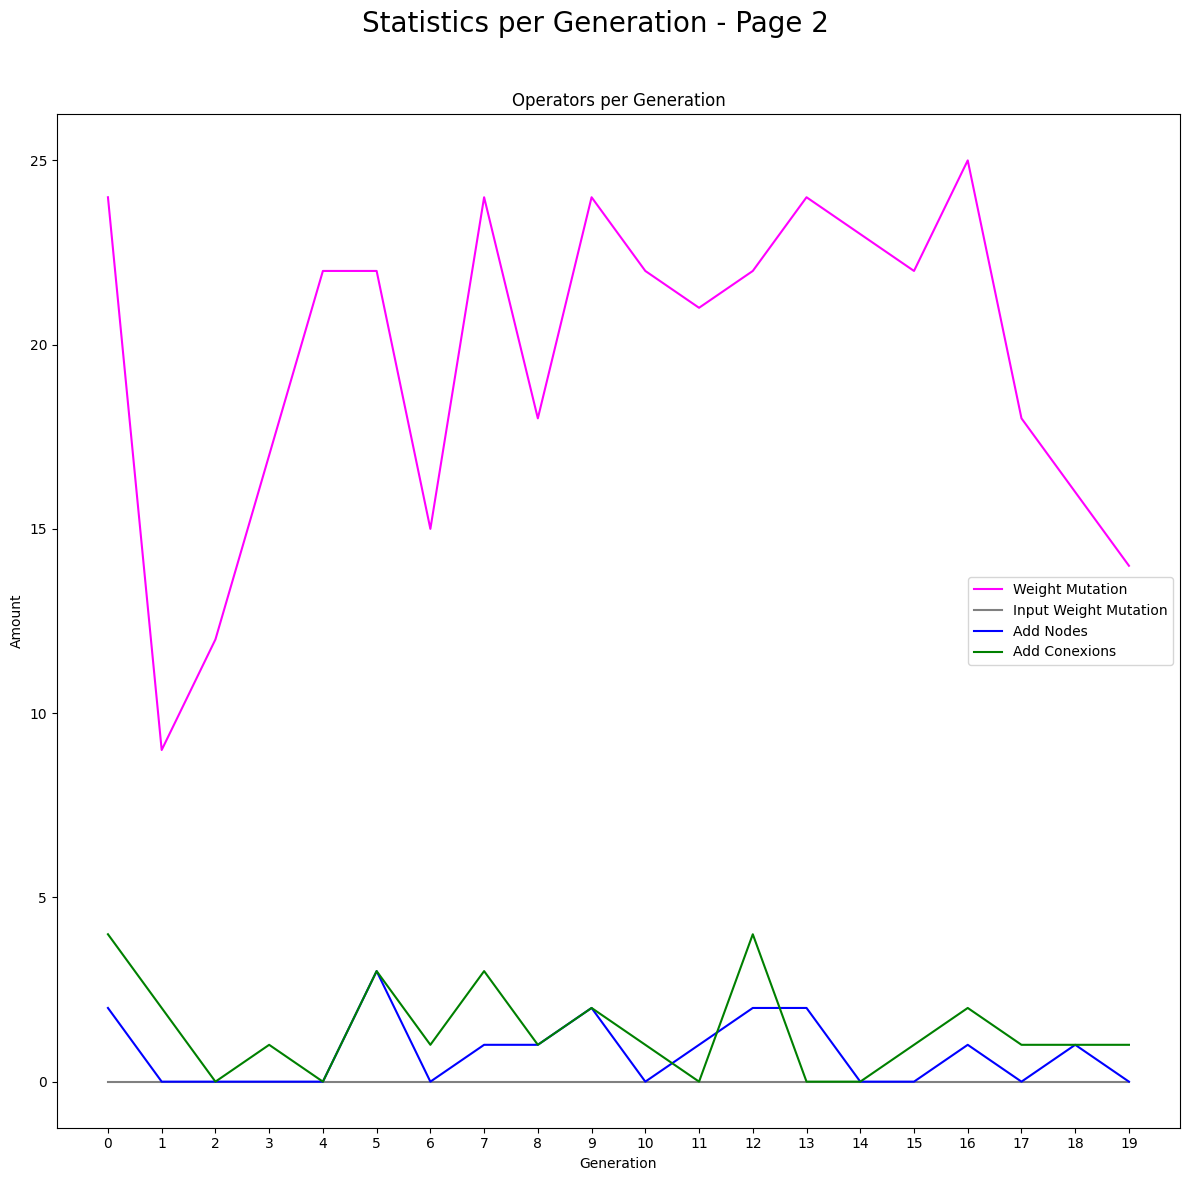

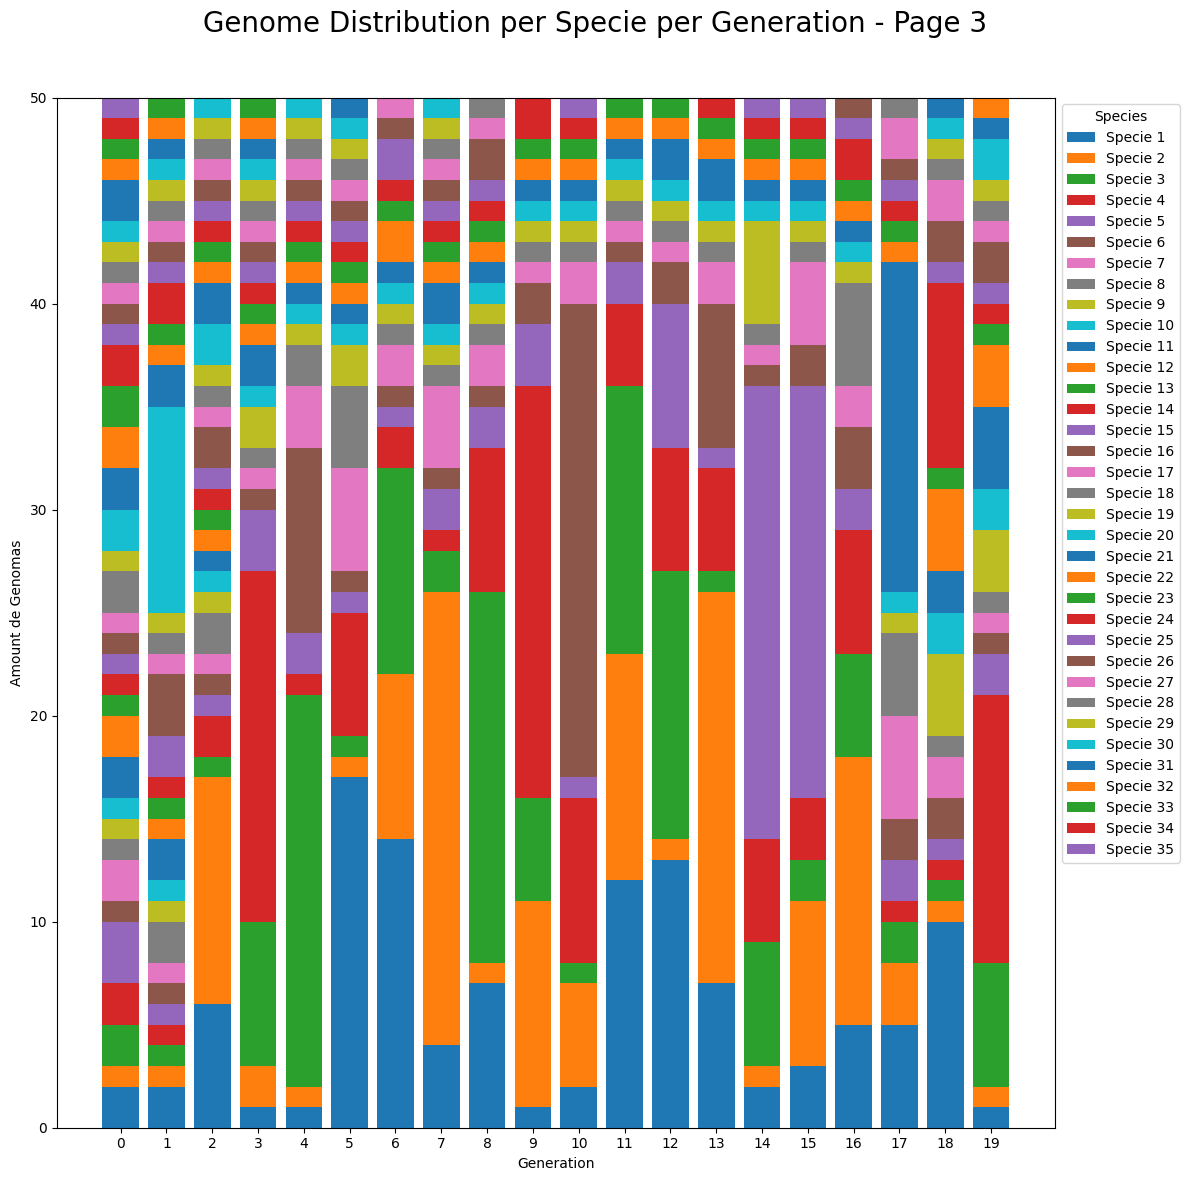

In [4]:
plot_information(trial)